In [185]:
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, transpile, ClassicalRegister
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import Parameter
import numpy as np
from qiskit import Aer, transpile

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.opflow.state_fns.dict_state_fn import DictStateFn
from qiskit.opflow.primitive_ops.pauli_op import PauliOp
from qiskit.test.mock import FakeVigo,FakeMelbourne,FakeManhattan,FakeRueschlikon,FakeAlmaden
from typing import List, Tuple
# TOKEN = "5faca914f56c3b654917cdc011970e14f394a397b54c19adfc4c5b0f629d9115da9b07e6898ab8dbc2a37ea0119d94747621db47bc13a6bdd37665a1f01d3ae3"
# IBMQ.save_account(TOKEN)
# provider = IBMQ.load_account()

In [186]:
def get_tiltedspin_trotter_circuit(num_qubits: int,
                                   J: float = 1.0,
                                   W: float = 0.1,
                                   trotter_steps: int = 5):
    """
    Define the trotter circuit for time evolution
    exp(-i(H1+ H2)t) = [exp(-iH1t/n)exp(-iH2t/n)]^n 
    n is the *trotter step*

    Create a circuit parametrized on t where t is the evolution time, to represent the 
    evolution of a system under the Hamiltonial H = J*H1 + J*H2 + W*H3.
    (Tilted spilt chain)
    Here H1 = Sum_ij(XiXj)
         H2 = Sum_ij(YiYj)
         H3 = Sum_i(Zi)
    
    [XX, YY] = 0 
    for exp(XX + YY) = exp(XX)exp(YY)

    num_qubits: Number of qubits

    returns:
    Trotterized gate, Trotterized circuit (for verification)
    """
    t = Parameter('t')

    Trot_qr = QuantumRegister(num_qubits, 'q')
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    # Circuit for xx and yy interaction
    for _ in range(trotter_steps):
        for i in range(0, num_qubits - 1):
            Trot_qc.rxx(2*t*J,i,i+1)
            Trot_qc.ryy(2*t*J,i,i+1)
            
        for i in range(0, num_qubits - 1):
            Trot_qc.rz(2*t*W*(i+1),i)
    # Convert custom quantum circuit into a gate
    #Trot_gate = Trot_qc.to_instruction()

    return Trot_qc, t


def simulate_tilted_spin_chain(num_qubits: int,
             initial_state: str,
             time = 4*np.pi,
             time_steps = 100,
             backend = None,
             trotter_steps: int = 40,
             tilts: Tuple[int] = (1, 0.1),
             expectation_op: str = 'IIZII'
             ):
    """
    Simulte a tited spin chain in quantum backend
    Hamiltonial H = J*H1 + J*H2 + W*H3.
    (Tilted spilt chain)
    Here H1 = Sum_ij(XiXj)
         H2 = Sum_ij(YiYj)
         H3 = Sum_i(Zi)
    *tilts* = (J, W)
    *initial_state* initial state. Superposition is not supported. Expect a classical
     initial state of length = len(num_qubits)
    *expectation_op* is the operator to find expecation value
    """
    initial_state = list(map(int, initial_state))
    if len(initial_state) != num_qubits:
        print("Invalid composite for initial state: Check length")
        return 
    
    if backend is None: 
        backend = AerSimulator()

    fids = []
    for target_time in np.linspace(0, time, time_steps):
    # The final time of the state evolution
        # Number of trotter steps
        trotter_steps =trotter_steps

        # Initialize quantum circuit for 3 qubits
        qr = QuantumRegister(num_qubits, 'q')
        cr = ClassicalRegister(num_qubits, 'c')
        qc = QuantumCircuit(qr,cr)

        #initialise the spin state. 
        [qc.x(qr[ind]) for ind, state in enumerate(initial_state) if state]
        
        # Simulate time evolution under H_heis3 Hamiltonian
        trotter_gate, param = get_tiltedspin_trotter_circuit(num_qubits, J =tilts[0], W=tilts[1], trotter_steps=trotter_steps)
        qc.append(trotter_gate, qr)
        # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
        qc = qc.bind_parameters({param: target_time/trotter_steps})

        [qc.measure(qr[i],cr[i]) for i in range(num_qubits)]
    
        circ = transpile(qc, backend)

        # Run and get counts
        result = backend.run(circ).result()
        
        try: 
            counts = result.get_counts()
        except: 
            counts = 0
        
        mit = mthree.M3Mitigation(backend)
        quasi3 = mit.apply_correction(counts, range(num_qubits), return_mitigation_overhead=True)

        fids.append(quasi3.expval(expectation_op))
    return fids

def tiltedlattice_unitary(J, W, t):
    """
    5 qubit unitary for tilted lattice spin chain evolution
    """
    J = 1
    W = 0.01
    
    XX = (X^X^I^I^I) + (I^X^X^I^I) + (I^I^X^X^I) + (I^I^I^X^X)
    YY = (Y^Y^I^I^I) + (I^Y^Y^I^I) + (I^I^Y^Y^I) + (I^I^I^Y^Y)
    #ZZ = (I^Z^Z) + (Z^Z^I)
    Zs = (Z^I^I^I^I) + 2*(I^Z^I^I^I) + 3*(I^I^Z^I^I) + 4*(I^I^I^Z^I) + 5*(I^I^I^I^Z)
    
    H = J*(XX + YY) + W*Zs
        
    return (t * H).exp_i()

def titled_spin5_exact(initial_state: DictStateFn = Zero^Zero^One^Zero^Zero,
                       expectation_op = I^I^Z^I^I,
                       tilts: Tuple = (1, 0.01),
                       time = 4*np.pi):
    """
    Excat Simulation of tilted spin chain  (5 spins)
    with tilts = (J, W)
    Hamiltonial H = J*H1 + J*H2 + W*H3.
    (Tilted spilt chain)
    Here H1 = Sum_ij(XiXj)
         H2 = Sum_ij(YiYj)
         H3 = Sum_i(Zi)
    """
    ts = np.linspace(0, time, 100)
    J, W = tilts
    expectation_value = []
    for t in ts: 
        state = (tiltedlattice_unitary(J, W, float(t)) @ initial_state)
        inner_prod = (~state@(expectation_op)@state).eval()
        expectation_value += [inner_prod]
    return expectation_value

In [187]:
backend = AerSimulator()
fids = simulate_tilted_spin_chain(num_qubits= 5, tilts=(1, 0.01), initial_state='00100', expectation_op='IIZII')
plt.plot(fids)

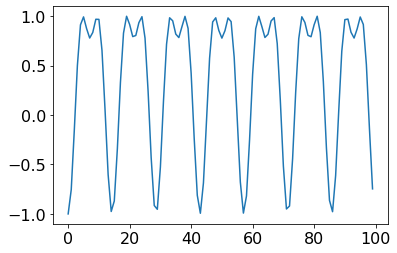

In [ ]:
expectation_value = titled_spin5_exact()
plt.plot(expectation_value)